In [1]:
# import important libraries 
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [2]:
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [3]:
df = pd.read_csv('C:/Users/techin/bank-app-review-analysis_week2/data/cleaned_reviews.csv')
df.head()

,review,rating,date,bank,source
0,niec,5,2025-06-04,CBE,Google Play
1,best app finance,5,2025-06-04,CBE,Google Play
2,yetemeta,1,2025-06-03,CBE,Google Play
3,engida kebede fetera,5,2025-06-03,CBE,Google Play
4,good,5,2025-06-03,CBE,Google Play


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Sentiment Analysis 
## TextBlob

In [6]:

def analyze_sentiment(text):
    analysis = TextBlob(str(text))
    polarity = analysis.sentiment.polarity
    if polarity > 0:
        label = 'positive'
    elif polarity < 0:
        label = 'negative'
    else:
        label = 'neutral'
    return pd.Series([polarity, label])

# Apply to DataFrame
df[['sentiment_textblob_score', 'sentiment_textblob_label']] = df['review'].apply(analyze_sentiment)

# View counts of each sentiment
print(df['sentiment_textblob_label'].value_counts())

sentiment_textblob_label
positive    3629
neutral     2340
negative     710
Name: count, dtype: int64


In [10]:
df.head()

,review,rating,date,bank,source,sentiment_textblob,sentiment_score,sentiment_label
0,niec,5,2025-06-04,CBE,Google Play,neutral,0.0,neutral
1,best app finance,5,2025-06-04,CBE,Google Play,positive,1.0,positive
2,yetemeta,1,2025-06-03,CBE,Google Play,neutral,0.0,neutral
3,engida kebede fetera,5,2025-06-03,CBE,Google Play,neutral,0.0,neutral
4,good,5,2025-06-03,CBE,Google Play,positive,0.7,positive


In [9]:
# Calculate sentiment counts per bank
sentiment_counts = df.groupby(['bank', 'sentiment_textblob_label']).size().unstack(fill_value=0)

# Convert counts to proportions
sentiment_proportions = sentiment_counts.div(sentiment_counts.sum(axis=1), axis=0)

# Display result
print(sentiment_proportions)

sentiment_textblob_label  negative   neutral  positive
bank                                                  
BOA                       0.237327  0.362903  0.399770
CBE                       0.088437  0.359297  0.552266
Dashen                    0.064039  0.204433  0.731527


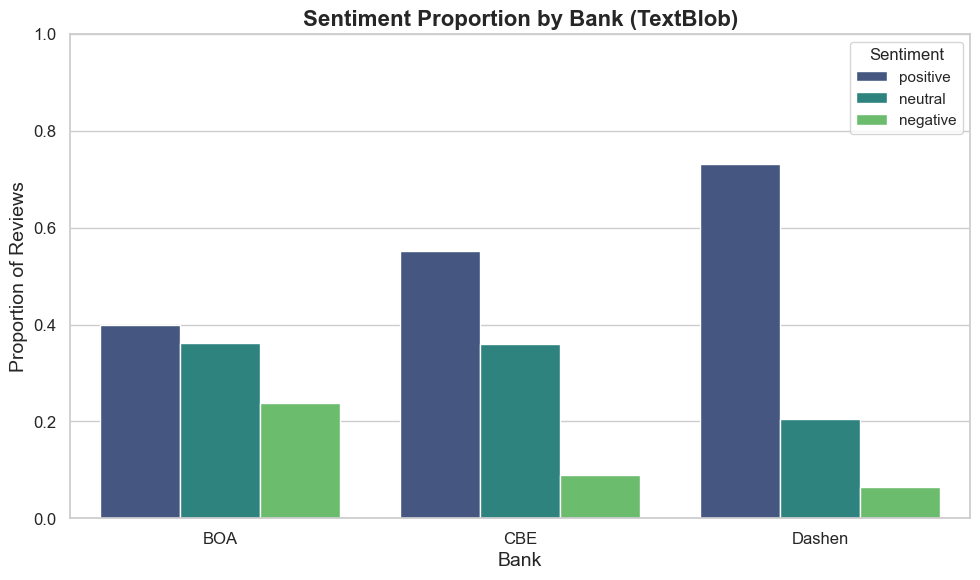

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index and melt the DataFrame
sentiment_long = sentiment_proportions.reset_index().melt(
    id_vars='bank', 
    var_name='Sentiment', 
    value_name='Proportion'
)

# Optional: define order for consistent display
sentiment_order = ['positive', 'neutral', 'negative']
sentiment_long['Sentiment'] = pd.Categorical(
    sentiment_long['Sentiment'],
    categories=sentiment_order,
    ordered=True
)

# Set plot style
sns.set(style="whitegrid", font_scale=1.1)

# Create grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=sentiment_long,
    x='bank',
    y='Proportion',
    hue='Sentiment',
    palette='viridis'
)

# Customize plot aesthetics
plt.title('Sentiment Proportion by Bank (TextBlob)', fontsize=16, fontweight='bold')
plt.xlabel('Bank', fontsize=14)
plt.ylabel('Proportion of Reviews', fontsize=14)
plt.ylim(0, 1)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Sentiment', title_fontsize=12, fontsize=11, loc='upper right', frameon=True)

# Layout adjustment
plt.tight_layout()
plt.show()

In [12]:
# Calculate sentiment counts per bank
sentiment_counts_rating = df.groupby(['rating', 'sentiment_textblob_label']).size().unstack(fill_value=0)

# Convert counts to proportions
sentiment_proportions_rating = sentiment_counts_rating.div(sentiment_counts_rating.sum(axis=1), axis=0)

# Display result
print(sentiment_proportions_rating)

sentiment_textblob_label  negative   neutral  positive
rating                                                
1                         0.337653  0.405184  0.257162
2                         0.233236  0.437318  0.329446
3                         0.106061  0.383117  0.510823
4                         0.041538  0.300000  0.658462
5                         0.015700  0.325705  0.658595


## Vader

In [13]:

nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

# Handle NaN and ensure string input
df['compound_score'] = df['review'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

# Convert score to label
def get_sentiment_label(score):
    if score >= 0.05:
        return 'posetive'
    elif score <= -0.05:
        return 'negative'
    else:
        return 'neutral'

df['sentiments_vader'] = df['compound_score'].apply(get_sentiment_label)

# Save output
df['sentiments_vader'].value_counts()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\techin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


sentiments_vader
posetive    3794
neutral     2082
negative     803
Name: count, dtype: int64

In [16]:
# Calculate sentiment counts per bank
sentiment_counts_rating_vader = df.groupby(['bank', 'sentiments_vader']).size().unstack(fill_value=0)

# Convert counts to proportions
sentiment_proportions_rating_vader = sentiment_counts_rating_vader.div(sentiment_counts_rating_vader.sum(axis=1), axis=0)

# Display result
print(sentiment_proportions_rating_vader)

sentiments_vader  negative   neutral  posetive
bank                                          
BOA               0.252304  0.328341  0.419355
CBE               0.105273  0.315819  0.578908
Dashen            0.036946  0.221675  0.741379


In [17]:
# Calculate sentiment counts per bank
sentiment_counts_rating_vader = df.groupby(['rating', 'sentiments_vader']).size().unstack(fill_value=0)

# Convert counts to proportions
sentiment_proportions_rating_vader = sentiment_counts_rating_vader.div(sentiment_counts_rating_vader.sum(axis=1), axis=0)

# Display result
print(sentiment_proportions_rating_vader)

sentiments_vader  negative   neutral  posetive
rating                                        
1                 0.381310  0.354707  0.263984
2                 0.250729  0.393586  0.355685
3                 0.127706  0.361472  0.510823
4                 0.063077  0.241538  0.695385
5                 0.015434  0.293507  0.691059


## Machine learning aproach(Naive bayes)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# Create labels based on ratings
df['label'] = df['rating'].apply(lambda x: 'positive' if x >= 4 else ('negative' if x <= 2 else 'neutral'))

# Vectorize text
vectorizer =  TfidfVectorizer()
X = vectorizer.fit_transform(df['review'])
y = df['label']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Naive Bayes
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.7709580838323353


In [19]:
df['predicted_sentiment'] = clf.predict(X)

# Count and display the number of reviews per sentiment
sentiment_counts = df['predicted_sentiment'].value_counts()
print(sentiment_counts)

predicted_sentiment
positive    5306
negative    1366
neutral        7
Name: count, dtype: int64


In [20]:
# Calculate sentiment counts per bank
sentiment_counts_rating_ML = df.groupby(['bank', 'predicted_sentiment']).size().unstack(fill_value=0)

# Convert counts to proportions
sentiment_proportions_rating_ML = sentiment_counts_rating_ML.div(sentiment_counts_rating_ML.sum(axis=1), axis=0)

# Display result
print(sentiment_proportions_rating_ML)

predicted_sentiment  negative   neutral  positive
bank                                             
BOA                  0.397465  0.000000  0.602535
CBE                  0.182794  0.001295  0.815911
Dashen               0.081281  0.000000  0.918719


In [21]:
# Calculate sentiment counts per bank
sentiment_counts_rating_ML = df.groupby(['rating', 'predicted_sentiment']).size().unstack(fill_value=0)

# Convert counts to proportions
sentiment_proportions_rating_ML = sentiment_counts_rating_ML.div(sentiment_counts_rating_ML.sum(axis=1), axis=0)

# Display result
print(sentiment_proportions_rating_ML)

predicted_sentiment  negative   neutral  positive
rating                                           
1                    0.663711  0.000000  0.336289
2                    0.577259  0.000000  0.422741
3                    0.238095  0.012987  0.748918
4                    0.058462  0.000000  0.941538
5                    0.012507  0.000266  0.987227


# Key word extraction

In [24]:
# Vectorize the dataset
vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(df['review'])

# Get top keywords
keywords = vectorizer.get_feature_names_out()
print("Top Keywords:", keywords)

Top Keywords: ['access' 'account' 'add' 'also' 'always' 'amazing' 'app' 'application'
 'apps' 'bad' 'balance' 'bank' 'banking' 'best' 'better' 'birr' 'branch'
 'ca' 'cbe' 'code' 'could' 'customer' 'dashen' 'day' 'developer' 'easy'
 'error' 'ethiopia' 'even' 'ever' 'every' 'excellent' 'experience' 'fast'
 'feature' 'fix' 'friendly' 'get' 'go' 'good' 'great' 'help' 'history'
 'issue' 'keep' 'life' 'like' 'love' 'make' 'mobile' 'money' 'much' 'need'
 'network' 'new' 'nice' 'one' 'open' 'option' 'payment' 'phone' 'please'
 'poor' 'previous' 'problem' 'properly' 'really' 'recent' 'say' 'see'
 'send' 'service' 'show' 'simple' 'sometimes' 'super' 'system' 'thank'
 'thanks' 'thing' 'time' 'transaction' 'transfer' 'try' 'update' 'updated'
 'use' 'used' 'user' 'using' 'verification' 'version' 'well' 'work'
 'working' 'worst' 'would' 'wow' 'በጣም' 'ነው']


In [25]:
# Vectorize the dataset
vectorizer = TfidfVectorizer(max_features=100, ngram_range=(2,3))
X = vectorizer.fit_transform(df['review'])

# Get top keywords
keywords = vectorizer.get_feature_names_out()
print("Top Keywords:", keywords)

Top Keywords: ['amazing app' 'app easy' 'app easy use' 'app ethiopia' 'app ever'
 'app ever seen' 'app fast' 'app good' 'app keep' 'app like' 'app make'
 'app thanks' 'app use' 'app work' 'app working' 'authorization code'
 'bad app' 'bank ethiopia' 'bank super' 'banking app' 'banking app ever'
 'banking system' 'best app' 'best application' 'best bank' 'best best'
 'best mobile' 'best mobile banking' 'better previous' 'ca use' 'cbe app'
 'cbe birr' 'cbe mobile' 'commercial bank' 'commercial bank ethiopia'
 'customer service' 'dashen bank' 'dashen super' 'dashen super app'
 'developer mode' 'developer option' 'easy fast' 'easy use'
 'error message' 'ever seen' 'every time' 'excellent app' 'fast easy'
 'fix bug' 'get verification' 'go bank' 'good app' 'good application'
 'good job' 'good service' 'good work' 'great app' 'keep crashing'
 'last update' 'latest update' 'life easy' 'like app' 'love app'
 'make life' 'make transaction' 'mobile app' 'mobile banking'
 'mobile banking app' 'nee

In [27]:
# Filter positive and negative reviews
positive_reviews = df[df['sentiments_vader'] == 'posetive']['review']
negative_reviews = df[df['sentiments_vader'] == 'negative']['review']

# Extract keywords from positive reviews
vectorizer_pos = TfidfVectorizer(max_features=10,ngram_range=(2,3), stop_words='english')
X_pos = vectorizer_pos.fit_transform(positive_reviews)
print("Top Keywords in Positive Reviews:", vectorizer_pos.get_feature_names_out())

# Extract keywords from negative reviews
vectorizer_neg = TfidfVectorizer(max_features=15,ngram_range=(2,3), stop_words='english')
X_neg = vectorizer_neg.fit_transform(negative_reviews)
print("Top Keywords in Negative Reviews:", vectorizer_neg.get_feature_names_out())

Top Keywords in Positive Reviews: ['banking app' 'best app' 'dashen bank' 'easy use' 'good app' 'great app'
 'mobile banking' 'mobile banking app' 'nice app' 'user friendly']
Top Keywords in Negative Reviews: ['app seen' 'app work' 'bad app' 'banking app' 'developer option'
 'error message' 'mobile banking' 'mobile banking app' 'new update'
 'poor app' 'recent transaction' 'use app' 'worst app' 'worst mobile'
 'worst mobile banking']


In [28]:
# Filter negative reviews only
negative_reviews = df[df['sentiments_vader'] == 'negative']
banks = negative_reviews['bank'].unique()

# Loop through each bank and extract top negative key phrases
for bank in banks:
    print(f"\nTop Negative Key Phrases for {bank}:")
    
    # Get only negative reviews for this bank
    bank_reviews = negative_reviews[negative_reviews['bank'] == bank]['review']
    
    # Vectorize using bigrams/trigrams
    vectorizer = TfidfVectorizer(max_features=20, ngram_range=(2, 3))
    X = vectorizer.fit_transform(bank_reviews)
    
    # Print top phrases
    top_phrases = vectorizer.get_feature_names_out()
    print(top_phrases)


Top Negative Key Phrases for CBE:
['app ever' 'bad app' 'error message' 'ever seen' 'every time'
 'fix problem' 'last update' 'mobile banking' 'new update'
 'none available' 'please fix' 'poor app' 'recent transaction'
 'show error' 'transaction history' 'use app' 'using app'
 'verification code' 'worst app' 'worst app ever']

Top Negative Key Phrases for BOA:
['app crash' 'app ever' 'bad app' 'banking app' 'banking app ever'
 'ca even' 'developer option' 'every time' 'make transaction'
 'mobile banking' 'mobile banking app' 'open app' 'please fix' 'poor app'
 'useless app' 'worst app' 'worst app ever' 'worst banking app'
 'worst mobile' 'worst mobile banking']

Top Negative Key Phrases for Dashen:
['app close' 'app close frequently' 'app ever' 'worst app' 'ነው ነገር ግን'
 'ነገር ግን' 'ነገር ግን ብር' 'አለበት አሱ' 'አለበት አሱ ቢስተካከል' 'አለው ሁሉ' 'አለው ሁሉ ጊዜ'
 'አሱ ቢስተካከል' 'አሱ ቢስተካከል star' 'አስከዛው ግን' 'አስከዛው ግን ሰጥቻለው'
 'የሚገርም aplication' 'የሚገርም aplication ነው' 'ያለ ፒን' 'ያለ ፒን መሆኑ' 'ጊዜ ትራንስፈር']


## K means clustering 

In [36]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
import pandas as pd

# Your list of phrases
phrases = keywords
# Load pre-trained Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the phrases
embeddings = model.encode(phrases)

# Choose number of clusters (try 5-10, or use methods like elbow)
num_clusters = 8

# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)
labels = kmeans.labels_

# Group phrases by cluster
clustered_phrases = pd.DataFrame({'Phrase': phrases, 'Cluster': labels})
for cluster_num in range(num_clusters):
    print(f"\nCluster {cluster_num}:")
    print(clustered_phrases[clustered_phrases['Cluster'] == cluster_num]['Phrase'].values)


Cluster 0:
['dashen bank' 'dashen super' 'dashen super app']

Cluster 1:
['app ever' 'app keep' 'app like' 'app make' 'app use' 'app work'
 'app working' 'like app' 'mobile app' 'open app' 'update app' 'use app'
 'using app']

Cluster 2:
['bank ethiopia' 'bank super' 'banking system' 'best bank' 'cbe birr'
 'commercial bank' 'commercial bank ethiopia' 'customer service' 'go bank'
 'see balance' 'send money' 'transfer money']

Cluster 3:
['best best' 'better previous' 'developer mode' 'developer option'
 'easy fast' 'easy use' 'ever seen' 'every time' 'fast easy' 'good job'
 'good service' 'good work' 'life easy' 'make life' 'need improvement'
 'one best' 'one step' 'please make' 'save time' 'simple use'
 'turn developer' 'user friendly' 'work properly' 'working properly']

Cluster 4:
['banking app' 'banking app ever' 'best mobile' 'best mobile banking'
 'ca use' 'cbe mobile' 'mobile banking' 'mobile banking app']

Cluster 5:
['amazing app' 'app easy' 'app easy use' 'app ethiopia' 'app

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

# Filter negative reviews only
negative_reviews = df[df['sentiments_vader'] == 'negative']
banks = negative_reviews['bank'].unique()

for bank in banks:
    print(f"\n🔴 Top Negative Clusters for {bank}:")

    # Get negative reviews for this bank
    bank_reviews = negative_reviews[negative_reviews['bank'] == bank]['review']

    # Vectorize using bigrams/trigrams
    vectorizer = TfidfVectorizer(max_features=100)
    X = vectorizer.fit_transform(bank_reviews)

    # Choose number of clusters based on review count
    n_clusters = min(5, len(bank_reviews))  # avoid too many clusters

    if n_clusters < 2:
        print("Not enough reviews to cluster.")
        continue

    # Cluster using KMeans
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)

    # Assign cluster labels
    bank_reviews_with_labels = pd.DataFrame({
        'review': bank_reviews.values,
        'cluster': kmeans.labels_
    })

    # Print clustered review summaries
    for cluster_num in range(n_clusters):
        cluster_reviews = bank_reviews_with_labels[bank_reviews_with_labels['cluster'] == cluster_num]['review']
        print(f"\n🧩 Cluster {cluster_num} ({len(cluster_reviews)} reviews):")
        for i, rev in enumerate(cluster_reviews.head(3)):  # print top 3 reviews from each cluster
            print(f" - {rev}")


🔴 Top Negative Clusters for CBE:

🧩 Cluster 0 (263 reviews):
 - recently big problem sending safaricom telebir even cbebirr wallet could anybody responsible fix frustrating 5 day money returned take account send mpesa corrected sent back money still afraid send
 - lower system everything
 - cbe app highly unreliable recent week frequently fails work properly ethio telecom safaricom network whether using mobile data week system entirely extended period making difficult access banking service app function intermittently lack consistency frustrating hope issue addressed soon influence removed essential service

🧩 Cluster 1 (89 reviews):
 - using app last two year problem stopped working 3 month ago tried transfer fund give error ca transaction inactive account
 - bad ca even load need improve service
 - boring mobil banking application use alternative private bank mobile banking apps

🧩 Cluster 2 (101 reviews):
 - like childish app make better worst ever seen
 - hate app
 - annoying mobi

In [39]:
df.to_csv('C:/Users/techin/bank-app-review-analysis_week2/data/cleaned_reviews_sentiment.csv')

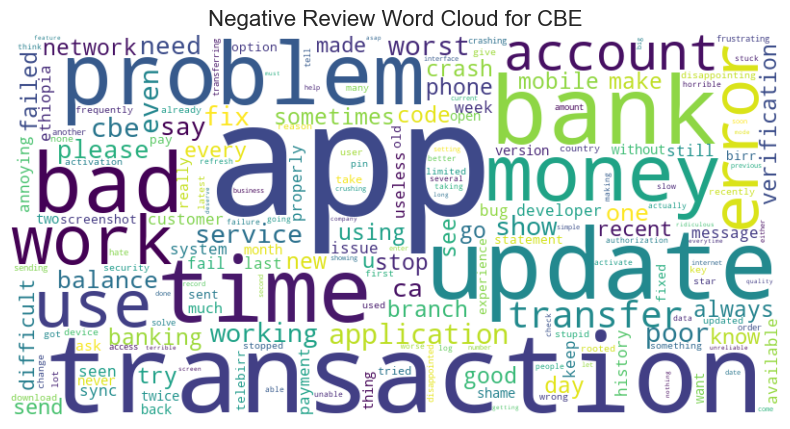

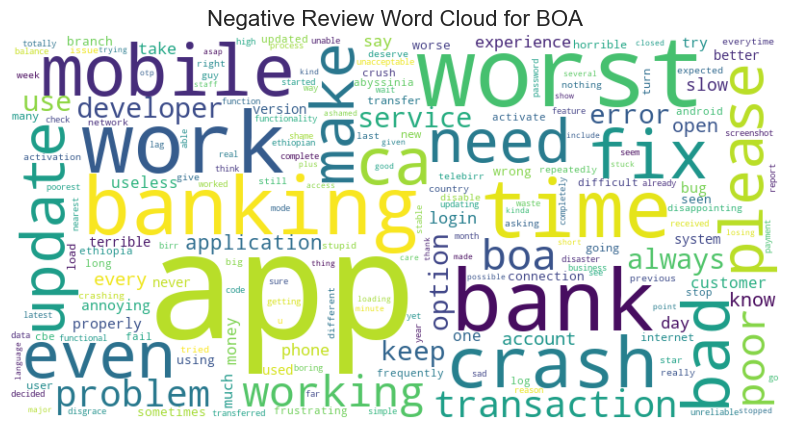

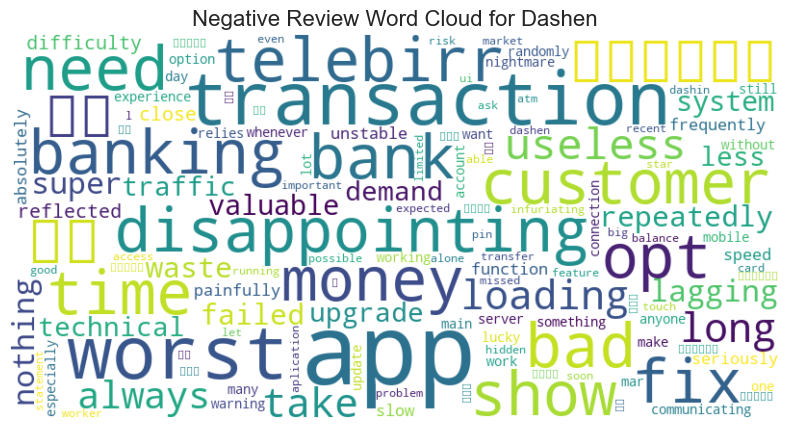

In [40]:
from wordcloud import WordCloud
# Generate word clouds for each bank
negative_reviews = df[df['sentiments_vader'] == 'negative']
banks = negative_reviews['bank'].unique()

for bank in banks:
    bank_reviews = negative_reviews[negative_reviews['bank'] == bank]
    text = " ".join(bank_reviews['review'].tolist())
    
    wordcloud = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Negative Review Word Cloud for {bank}", fontsize=16)
    plt.show()


#### 🏦 CBE (Commercial Bank of Ethiopia)
- Frequent issues include:
  - App crashes
  - System/network failures
  - Problems with transfers (especially to wallets like **CBE Birr**)
  - Poor customer service
  - Updates disabling necessary features like **screenshots**

#### 🏦 BOA (Bank of Abyssinia)
- Common complaints revolve around:
  - Frequent app crashes
  - Login failures
  - Persistent bugs
  - App being offline
  - Overall perception as the **"worst"** or a **"disgrace"**

#### 🏦 Dashen Bank
- Negative feedback often mentions:
  - Lagging performance
  - App instability and frequent closure
  - Failed or unreliable transactions
  - Security concerns, especially around **PIN handling**
  
  
  
It's striking how similar the dominant themes are across all three banks. The mobile banking app seems to be a universal and significant source of negative feedback in Ethiopia. Common complaints include:
- App crashing/not working/unstable.
- Difficulty with transactions.
- Slow performance and wasted time.
- Issues with updates.
- General poor service.
While each bank has slight variations (e.g., Telebirr being very prominent for Dashen, "crash" being extremely large for BOA, and "update" being highly prominent for CBE), the overarching narrative from negative reviews for major Ethiopian banks appears to be centered on the performance and reliability of their digital banking applications and the associated transaction processes.